In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
raw_data = pd.read_excel('/content/drive/My Drive/FRIM Dry Run Defect Log.xlsx', header=None)

### Drop unnecessary data and columns
#### First 94 rows contained data in which every gel was being recorded. 

In [0]:
raw_data = raw_data.iloc[93:]
raw_data = raw_data.drop(columns=[7,8])
raw_data.columns = ['Date', 'Scan ID', 'Defect', 'Cluster Qty', 'Location (x)', 'Glass #', 'Sequence']
raw_data.reset_index(drop=True, inplace=True)
raw_data.replace(["gel", "Gels"], "Gel")
raw_data["Defect"].fillna("None", inplace=True)
raw_data.head(5)

,Date,Scan ID,Defect,Cluster Qty,Location (x),Glass #,Sequence
0,2019-09-04 00:00:00,4914,Gel,1,0.6,1,1
1,2019-09-04 00:00:00,4914,Carbon,1,NaN,NaN,2
2,2019-09-04 00:00:00,4914,Gel,1,1.2,2,3
3,2019-09-04 00:00:00,4914,None,0,1.8,3,4
4,2019-09-04 00:00:00,4914,None,0,2.4,4,5


In [0]:
merged_cells = raw_data['Location (x)'].isna().sum()
row_count = len(raw_data) - merged_cells

In [0]:
data = pd.DataFrame(data=None, index=np.arange(0, row_count), columns=['Scan ID', 'Gel', 'Carbon', 'Circ', 'Misc', 'X', '#', 'Sequence'])

#### Removing merged cells and merging defect values onto respective new columns  

In [0]:
def fill(orig, dest):
  for i in range(len(orig)):
    if not np.isnan(orig.loc[i, 'Location (x)']):
      dest.loc[i, 'Scan ID'] = orig.loc[i, 'Scan ID']
      dest.loc[i, 'X'] = orig.loc[i, 'Location (x)']
      dest.loc[i, '#'] = orig.loc[i, 'Glass #']
      dest.loc[i, 'Sequence'] = orig.loc[i, 'Sequence']
      if orig.loc[i, 'Defect'] in ["Gel", "Carbon", "Circ", "Misc"]:
        dest.loc[i, str(orig.loc[i, 'Defect']).title()] = orig.loc[i, "Cluster Qty"]  
    else:
        dest.loc[i-1, str(orig.loc[i, 'Defect']).title()] = orig.loc[i, "Cluster Qty"]


fill(raw_data, data)
data = data[pd.notnull(data['Sequence'])]
data.reset_index(drop=True, inplace=True)
data['Sequence'] = np.arange(len(data))
zero_defects = {'Gel': 0, 'Carbon': 0, 'Circ': 0, 'Misc': 0}
data.fillna(value=zero_defects, inplace=True)
data['Total Defects'] = data.loc[:, 'Gel':'Misc'].sum(axis=1)
data['No Defects'] = np.where(((data['Gel'] == 0) & (data['Carbon'] == 0) & (data['Circ'] == 0) & (data['Misc'] == 0)), True, False)

### New data format

In [0]:
data.head(5)

,Scan ID,Gel,Carbon,Circ,Misc,X,#,Sequence,Total Defects,No Defects
0,4914,1,1,0,0,0.6,1,0,2,False
1,4914,1,0,0,0,1.2,2,1,1,False
2,4914,0,0,0,0,1.8,3,2,0,True
3,4914,0,0,0,0,2.4,4,3,0,True
4,4914,2,0,0,0,3,5,4,2,False


### Total Defects per square. 0 Defects: 323 Squares, 1 defect: 330 sqaures ... ...

In [0]:
data.groupby('Total Defects').size()

Total Defects
0    323
1    330
2    145
3     33
4     13
5      4
6      5
dtype: int64

### Defect count per square. 0 defects: 432 squares, 1 defect: 308 squares ... ...

In [0]:
data['Gel'].value_counts()

0    402
1    308
2    105
3     24
4      9
6      3
5      2
Name: Gel, dtype: int64

In [0]:
data['Gel'].describe()

count    853.000000
mean       0.766706
std        0.934833
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: Gel, dtype: float64

## Worst Case Scenario

#### This cell sums the qualities of each group of 44 squares (26.4 meters) and finds the max values amongst those groups. In this case, it can be seen that the worst group in the gels category had 86 of them, while the worst performer for carbons had 22. The worst group when it came to total defects had 99 along its length. The run with least amount of defects had 31 clean squares for a 70% purity so to say.  

In [0]:
data.rolling(44).sum().max()

Scan ID          217091.0
Gel                  86.0
Carbon               22.0
Circ                  0.0
Misc                  2.0
X                   588.4
#                   970.0
Sequence          36542.0
Total Defects        99.0
No Defects           31.0
dtype: float64

### Best Case Scenario

In [0]:
data.rolling(44).sum().min()

Scan ID          216223.0
Gel                   8.0
Carbon                1.0
Circ                  0.0
Misc                  0.0
X                   429.6
#                   716.0
Sequence            946.0
Total Defects        15.0
No Defects            5.0
dtype: float64

### Average Scenario

In [0]:
data.rolling(44).sum().mean()

Scan ID          216674.015873
Gel                  33.448148
Carbon                8.282716
Circ                  0.000000
Misc                  0.271605
X                   527.433580
#                   878.150617
Sequence          18744.000000
Total Defects        42.002469
No Defects           16.792593
dtype: float64

### Verifying the Gel max run of 86 which can be seen at row 166.


In [0]:
ld = data.rolling(44).sum()
ld.loc[ld['Gel'] >= 80]

,Scan ID,Gel,Carbon,Circ,Misc,X,#,Sequence,Total Defects,No Defects
163,216362.0,80.0,12.0,0.0,0.0,498.4,814.0,6226.0,92.0,8.0
164,216363.0,83.0,12.0,0.0,0.0,502.0,820.0,6270.0,95.0,7.0
165,216364.0,85.0,13.0,0.0,0.0,505.6,826.0,6314.0,98.0,6.0
166,216365.0,86.0,13.0,0.0,0.0,509.2,832.0,6358.0,99.0,5.0
167,216366.0,84.0,12.0,0.0,0.0,512.8,838.0,6402.0,96.0,5.0
168,216367.0,81.0,12.0,0.0,0.0,516.4,844.0,6446.0,93.0,6.0
170,216369.0,80.0,12.0,0.0,0.0,523.6,856.0,6534.0,92.0,6.0
171,216370.0,81.0,12.0,0.0,0.0,527.2,862.0,6578.0,93.0,5.0
172,216371.0,80.0,12.0,0.0,0.0,530.8,868.0,6622.0,92.0,6.0
173,216372.0,81.0,10.0,0.0,0.0,534.4,874.0,6666.0,91.0,6.0


### Shown here are the Gel rows from 122 to 166 to verify that there are indeed 86 gels in that particular run

In [0]:
data['Gel'].iloc[122:167]

### Sum of these defects

In [0]:
data['Gel'].iloc[122:167].sum()

86

In [0]:
# data.to_excel('FRIM Roll Data.xlsx', sheet_name='Shell Film - 1.5 mil PE01')

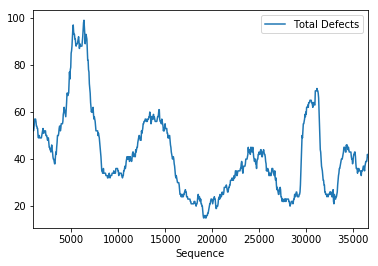

In [0]:
ld.plot(x="Sequence", y="Total Defects")

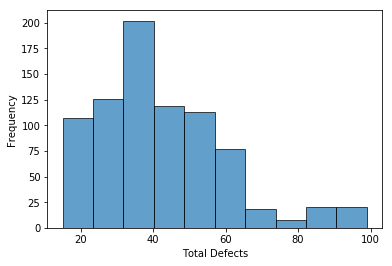

In [0]:
plt.xlabel('Total Defects')
ld['Total Defects'].plot.hist(ec='black', histtype='bar', alpha=0.7)